In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rioxarray as rioxr
import xarray as xr

# Using Skicit-learn to split data into training and testing sets 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix

import rasterio
import geopandas as gpd

import pystac_client 
import planetary_computer as pc

from shapely.geometry import Polygon
from sklearn.metrics import RocCurveDisplay

#import iceplant_detection_functions as ipf

In [12]:
def iceplant_counts(df):
    return df.filter(items=['iceplant']).groupby(['iceplant']).size().reset_index(name='count')

def test_train_from_df(df,test_size=0.3):
    # Labels are the values we want to predict
    labels = np.array(df['iceplant'])
    #Convert to numpy array
    features = np.array(df.drop('iceplant', axis = 1))
    return train_test_split(features, labels, test_size = test_size, random_state = 42)

# --- check proportions of ice plant vs no ice plant in train/test sets
def test_train_proportions(train_labels, test_labels):
    print('TRAIN SET: Iceplant / no iceplant counts')
    unique, counts = np.unique(train_labels,return_counts=True)
    print(np.column_stack((unique,counts)), '\n')

    print('TEST SET: Iceplant / no iceplant counts')
    unique, counts = np.unique(test_labels,return_counts=True)
    print(np.column_stack((unique,counts)))
    print()
    return

# --- check shapes of train/test features/labels
def  train_test_shapes(train_features, train_labels, test_features, test_labels):
    print('Training Features Shape:', train_features.shape) 
    print('Training Labels Shape:', train_labels.shape) 
    print('Testing Features Shape:', test_features.shape) 
    print('Testing Labels Shape:', test_labels.shape)
    print()
    return

# **********************************************************************************************************

def print_accuracy_info(test_labels,predictions_class):
    N = test_labels.shape[0]
    results = confusion_matrix(test_labels,predictions_class, normalize = 'true')
    
    confmtx = confusion_matrix(test_labels,predictions_class)
    print('true negatives:', confmtx[0,0], 
          '    false positives:', confmtx[0,1])
    print('false negatives:', confmtx[1,0], 
          '    true positives:', confmtx[1,1])
    print()
    unique, counts = np.unique(test_labels,return_counts=True)

    print('true negative %:', np.round(confmtx[0,0]/counts[0]*100,2))
    print('true positive rate %:', np.round(confmtx[1,1]/counts[1]*100,2))
    print()
    print('accuracy %:', np.round( (confmtx[1,1] + confmtx[0,0])/test_labels.shape[0]*100,2))
    return

def plot_roc(rfc, test_features, test_labels):
    ax = plt.gca()
    rf_disp = RocCurveDisplay.from_estimator(rfc, test_features, test_labels, ax=ax)
    return

def print_abs_errors(predictions_class, test_labels):# Calculate the absolute errors
    errors_class = abs(predictions_class - test_labels)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors_class), 2))
    return

def print_rfc_evaluation(rfc, test_features, test_labels, predictions):
    print_abs_errors(predictions, test_labels)
    print()
    print_accuracy_info(test_labels,predictions)
    plot_roc(rfc, test_features, test_labels)
    print()
    return

def open_window_in_scene(itemid, reduce_box):
    # accesing Azure storage using pystac client
    URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
    catalog = pystac_client.Client.open(URL)

    itemid = itemid,
    search = catalog.search(
        collections=["naip"],
        ids = itemid
    )
    item = list(search.get_items())[0]
    # sign and open item
    href = pc.sign(item.assets["image"].href)
    ds = rasterio.open(href)


    reduce = gpd.GeoDataFrame({'geometry':[reduce_box]}, crs="EPSG:4326")
    reduce = reduce.to_crs(ds.crs)

    win = ds.window(*reduce.total_bounds)
    subset = rasterio.open(href).read([1,2,3,4], window=win)
    return subset


def predict_over_subset(itemid, reduce_box,rfc):
    subset = open_window_in_scene(itemid, reduce_box)
    # reshape image into a np.array where each row is a pixel and the columns are the bands
    pixels = subset.reshape([4,-1]).T
    predictions_class = rfc.predict(pixels)
    # turn back into original raster dimensions
    return predictions_class.reshape([subset.shape[1],-1])

# **********************************************************************************************************
# image is a (4,m,n) np array in which bands are r,g,b,nir

def select_ndvi_df(image,thresh=0.2):
    # reshape image into a np.array where each row is a pixel and the columns are the bands
    pixels = image.reshape([4,-1]).T
    df = pd.DataFrame(pixels, columns=['r','g','b','nir'])
    df['ndvi']=(df.nir.astype('int16') - df.r.astype('int16'))/(df.nir.astype('int16') + df.r.astype('int16'))
    vegetation = df[df.ndvi>thresh]
    vegetation.drop(labels=['ndvi'],axis=1, inplace=True)
    return vegetation

# ---------------------------------
def df_backto_image(image, df):
    reconstruct = np.zeros((image.shape[1],image.shape[2]))
    for n in df.index:
        if df.prediction[n]==1:
            i = int((n)/reconstruct.shape[1])
            j = (n) % reconstruct.shape[1]
            reconstruct[i][j] = 1
    return reconstruct

# ---------------------------------
def mask_ndvi_and_predict(itemid, reduce_box, rfc):
    image = open_window_in_scene(itemid, reduce_box)
    veg = select_ndvi_df(image)
    index = veg.index
    features = np.array(veg)
    predictions_class = rfc.predict(features)
    c = {'prediction':predictions_class}
    predictions_df = pd.DataFrame(c, index = index)
    
    return df_backto_image(image,predictions_df)

# **********************************************************************************************************
def plot_window_in_scene(itemid, reduce_box):
    # accesing Azure storage using pystac client
    URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
    catalog = pystac_client.Client.open(URL)

    itemid = itemid,
    search = catalog.search(
        collections=["naip"],
        ids = itemid
    )
    item = list(search.get_items())[0]
    # sign and open item
    href = pc.sign(item.assets["image"].href)
    ds = rasterio.open(href)
    
    reduce = gpd.GeoDataFrame({'geometry':[reduce_box]}, crs="EPSG:4326")
    reduce = reduce.to_crs(ds.crs)
    win = ds.window(*reduce.total_bounds)
    
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.imshow(np.moveaxis(rasterio.open(href).read([1,2,3], window=win),0,-1))
    plt.show()
    
    return

# image is a (4,m,n) np array in which bands are r,g,b,nir

def select_ndvi_df(image,thresh=0.2):
    # reshape image into a np.array where each row is a pixel and the columns are the bands
    pixels = image.reshape([4,-1]).T
    df = pd.DataFrame(pixels, columns=['r','g','b','nir'])
    df['ndvi']=(df.nir.astype('int16') - df.r.astype('int16'))/(df.nir.astype('int16') + df.r.astype('int16'))
    vegetation = df[df.ndvi>thresh]
    vegetation.drop(labels=['ndvi'],axis=1, inplace=True)
    return vegetation


# ---------------------------------

def select_ndvi_image(itemid, reduce_box):
    subset = open_window_in_scene(itemid, reduce_box)
    df = select_ndvi_df(subset)
    reconstruct = np.zeros((subset.shape[1],subset.shape[2]))
    for n in df.index:
        i = int((n)/reconstruct.shape[1])
        j = (n) % reconstruct.shape[1]
        reconstruct[i][j] = 1
    return reconstruct

## MODEL 3:
- adding more non-iceplant vegetation points
- covariates: r,g, b, nir, lidar

In [3]:
fp = os.path.join(os.getcwd(),'training_set','aux_data','trainset_non_iceplant_vegetation_w_lidar','trainset_non_iceplant_vegetation_w_lidar.csv')
noniceplant_features_df = pd.read_csv(fp)
noniceplant_features_df.head(3)

,Unnamed: 0,r,g,b,nifr,lidar,iceplant,geometry
0,0,163,144,116,183,0,0,POINT (237140.55244983424 3814526.169987386)
1,1,114,103,95,140,3,0,POINT (236884.12087633729 3814547.904989663)
2,2,59,67,69,137,19,0,POINT (237192.64798213687 3814447.774569938)


In [4]:
fp = os.path.join(os.getcwd(),'training_set','aux_data','trainset_BIG_w_lidar','trainset_BIG_w_lidar.csv')
features_df = pd.read_csv(fp)
features_df.head(3)

,Unnamed: 0,r,g,b,nifr,lidar,iceplant,geometry
0,0,87,80,87,140,3,1,POINT (238502.90962098932 3810767.0101709934)
1,1,85,81,84,149,2,1,POINT (238531.08502453056 3810765.5025521284)
2,2,96,83,89,149,2,1,POINT (238514.12151877387 3810770.2447426594)


In [5]:
# add non-iceplant vegetation points sample to BIG training set 
features_df = pd.concat([features_df,
                         noniceplant_features_df.sample(frac=0.01)])
features_df.drop(['geometry','Unnamed: 0'],axis=1,inplace=True)
iceplant_counts(features_df)

,iceplant,count
0,0,5113
1,1,1609


In [6]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = test_train_from_df(features_df)

train_test_shapes(train_features, train_labels, test_features, test_labels)
test_train_proportions(train_labels, test_labels)

Training Features Shape: (4705, 5)
Training Labels Shape: (4705,)
Testing Features Shape: (2017, 5)
Testing Labels Shape: (2017,)

TRAIN SET: Iceplant / no iceplant counts
[[   0 3590]
 [   1 1115]] 

TEST SET: Iceplant / no iceplant counts
[[   0 1523]
 [   1  494]]



In [7]:
# Train random forest classifier
rfc = RandomForestClassifier(n_estimators = 100, 
                           random_state = 42)
rfc.fit(train_features,train_labels)

RandomForestClassifier(random_state=42)

In [8]:
predictions = rfc.predict(test_features)

Mean Absolute Error: 0.01

true negatives: 1516     false positives: 7
false negatives: 15     true positives: 479

true negative %: 99.54
true positive rate %: 96.96

accuracy %: 98.91



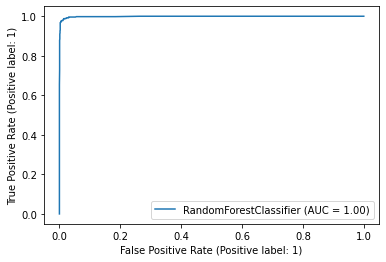

In [9]:
print_rfc_evaluation(rfc, test_features, test_labels, predictions)

## Applying MODEL 3 to NAIP subsets

In [3]:
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
itemid='ca_m_3411934_sw_11_060_20180722_20190209'

catalog = pystac_client.Client.open(URL)

search = catalog.search(
        collections=["naip"],
        ids = itemid
    )
item = list(search.get_items())[0]
href = pc.sign(item.assets["image"].href)

In [4]:
# rioxarray of complete naip scene (two ways of getting it, second probably better?)
naip_scene = rioxr.open_rasterio(rasterio.open(href))
#naip_scene = xr.open_dataset(href, engine='rasterio')
naip_scene

<xarray.DataArray (band: 4, y: 12340, x: 10420)>
[514331200 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 2.355e+05 2.355e+05 ... 2.417e+05 2.417e+05
  * y            (y) float64 3.815e+06 3.815e+06 ... 3.807e+06 3.807e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [5]:
# Campus Point bounding box
reduce_box = Polygon([
    [-119.8534713523,34.4028697719],
    [-119.8409772016,34.4028697719],
    [-119.8409772016,34.4129840686],
    [-119.8534713523,34.4129840686],
    [-119.8534713523,34.4028697719]])

ds = rasterio.open(href) 

reduce = gpd.GeoDataFrame({'geometry':[reduce_box]}, crs="EPSG:4326")
reduce = reduce.to_crs(ds.crs)

In [7]:
# mask naip scene with Campus Point bounding box
naip_subset = naip_scene.rio.clip_box(*reduce.total_bounds)
naip_subset

<xarray.DataArray (band: 4, y: 1925, x: 1969)>
[15161300 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 2.377e+05 2.377e+05 ... 2.389e+05 2.389e+05
  * y            (y) float64 3.812e+06 3.812e+06 3.812e+06 ... 3.81e+06 3.81e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

### Open, mask and resample LIDAR raster

In [10]:
fp = os.path.join(os.getcwd(),'training_set','3mlidar_over_campuspoint_naip_scene.tif')
lidar = rioxr.open_rasterio(fp)

# resample using the naip_subset
lidar_match = lidar.rio.reproject_match(naip_subset)
lidar_match = lidar_match.squeeze()
lidar_match

<xarray.DataArray (y: 1925, x: 1969)>
array([[    3,     3,     3, ...,     1,     1,     1],
       [    3,     3,     3, ...,     1,     1,     1],
       [    3,     3,     3, ...,     1,     1,     1],
       ...,
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999]], dtype=int16)
Coordinates:
  * x            (x) float64 2.377e+05 2.377e+05 ... 2.389e+05 2.389e+05
  * y            (y) float64 3.812e+06 3.812e+06 3.812e+06 ... 3.81e+06 3.81e+06
    band         int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    _FillValue:    -9999

### Add LIDAR as feature to NAIP subset

In [27]:
image = naip_subset.to_numpy()

veg = select_ndvi_df(image)

#features = np.array(veg)

#predictions_class = rfc.predict(features)
#c = {'prediction':predictions_class}
#predictions_df = pd.DataFrame(c, index = index)

/tmp/ipykernel_1060/1968669404.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


In [30]:
image.shape

(4, 1925, 1969)

In [29]:
lidar_np = lidar_match.to_numpy()
lidar_np.shape

(1925, 1969)

In [32]:
lidar_veg = []
for n in veg.index:
    i = int((n)/lidar_np.shape[1])
    j = (n) % lidar_np.shape[1]
    lidar_veg.append(lidar_np[i][j])

veg['lidar']=lidar_veg
veg

,r,g,b,nir,lidar
31,95,92,98,156,4
34,101,102,103,157,4
35,98,100,99,148,4
36,93,95,98,142,4
37,82,81,89,153,4
...,...,...,...,...,...
3788458,34,49,63,61,-9999
3788459,33,45,61,51,-9999
3788462,38,47,61,67,-9999
3788463,37,49,63,68,-9999


In [33]:
veg[veg.lidar == -9999]

,r,g,b,nir,lidar
1096569,62,73,81,102,-9999
1964970,48,66,83,79,-9999
1964971,57,105,85,107,-9999
2091001,42,85,79,74,-9999
2091002,52,100,88,94,-9999
...,...,...,...,...,...
3788458,34,49,63,61,-9999
3788459,33,45,61,51,-9999
3788462,38,47,61,67,-9999
3788463,37,49,63,68,-9999
